# Load Libraries

In [50]:
import pandas as pd
import numpy as np
import random as rnd
import datetime

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_style('whitegrid')
%matplotlib inline

# plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestClassifier
#for normalizing data
from sklearn.preprocessing import MinMaxScaler

import cufflinks as cf
cf.go_offline()

from fastai.tabular.all import *

# SKlearn# SKlearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

from time import time


from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.base import clone

#from tune_sklearn import TuneSearchCV
#from tabulate import tabulate

import joblib


from tqdm import tqdm

# Load Data

In [51]:
filepath = "/Users/Kapil/PycharmProjects/stock-price"
train = pd.read_csv(filepath + "/data/train.csv")
test = pd.read_csv(filepath + "/data/test.csv")

In [52]:
SEED = 13
np.random.seed(SEED)

In [53]:
Y_trainW = train['Up']
X_trainW = train.drop(['Up'], axis = 1)

X_test = test


### Create Validation Dataset

In [54]:
#Last 20% of the train data as Validation data
X_val = X_trainW[int(0.7*len(X_trainW)):]
Y_val = Y_trainW[int(0.7*len(X_trainW)):]

X_train = X_trainW[:int(0.7*len(X_trainW))]
Y_train = Y_trainW[:int(0.7*len(X_trainW))]

## Functions
#### Preprocessing function

In [55]:
def preproc(df):
    #df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df_colRef = df
    scaler = MinMaxScaler(feature_range=(0, 1))
    df.index = df['Date']
    add_datepart(df, 'Date')
    df.drop('Elapsed', axis=1, inplace=True)
    df.replace({False: 0, True: 1}, inplace=True)
    df = scaler.fit_transform(df)
    df = pd.DataFrame(df, columns = df_colRef.columns)

    return  df

#### Submission format function

In [56]:
def submitformat(df, test_df):
    df[df > 0.5] = 1
    df[df <= 0.5] = 0
    df = pd.DataFrame(df)
    df.index = test_df.index
    df = df.iloc[5::6, :]
    df = df.astype(int)
    return df

### Preprocess Data

In [57]:
X_trainW = preproc(X_trainW)
X_train = preproc(X_train)
X_val = preproc(X_val)
X_test = preproc(X_test)

In [58]:
X_train.head()

,Date,Open,High,Low,Close
0,2004-01-02,50.85,50.91,50.62,50.72
1,2004-01-05,50.75,50.84,50.61,50.79
2,2004-01-06,50.87,51.26,50.86,51.15
3,2004-01-07,51.45,51.54,51.29,51.51
4,2004-01-08,51.15,51.33,51.02,51.28


## Models
#### Logistic Regression Tuning

In [ ]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  solver=solver)

model1 = GridSearchCV(LogisticRegression(solver='liblinear'),
                    param_grid=param_grid,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)


#### Decision Tree tuning

In [ ]:
config = {
    'criterion' : ['gini', 'entropy'],
    'min_samples_leaf': list(range(1,5)),
    "max_depth": list(range(1,10)),
    "min_samples_split" : list(range(2,10))
    #"max_leaf_nodes" : list(range(200))
}
model2 = TuneSearchCV(DecisionTreeClassifier(random_state=SEED),
                          config,
                          scoring='accuracy',
                          n_jobs=-1, cv =5,
                          search_optimization='bayesian',
                          verbose=1,
                          random_state=SEED)

#### Random Forest Tuning

In [ ]:
config = {'bootstrap': [True, False],
          "max_depth": list(range(1,10)),
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': list(range(1,10)),
          "min_samples_split" : list(range(2,10)),
          'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50,55,60]}

model3 = TuneSearchCV(RandomForestClassifier(n_jobs= 1, verbose = 1,
                                                  random_state=SEED),
                          config,
                          scoring='accuracy',
                          n_jobs=1, cv=5,
                          search_optimization='bayesian',
                          verbose=1,
                          random_state=SEED)


#### LightGBM Tuning

In [ ]:
config = {
    'n_estimators': [5, 7, 10, 12, 15, 20, 25, 30, 35, 40],
    "colsample_bytree": [0.1, 0.2, 0.3, 0.4,0.5],
    "max_depth": list(range(1,10)),
    "num_leaves": [10, 12, 15, 17,20,22,25, 30, 35],
    "reg_lambda": [1.1, 1.2, 1.3],
    "min_split_gain": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5],
    "subsample": [0.5, 0.7, 0.8, 0.9, 1],
    "learning_rate": [0.1, 0.12, 0.15, 0.16,0.17,0.18, 0.175, 0.2]
}
model4 = TuneSearchCV(LGBMClassifier(n_jobs=-1, random_state=SEED),
                          config,
                          scoring='accuracy',
                          n_jobs=-1, cv=5,
                          search_optimization='bayesian',
                          verbose=1,
                          random_state=SEED)

#### XGBoost Tuning

In [ ]:
config = {
    'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50,55,60],
    "colsample_bytree": [0.1, 0.2, 0.3, 0.4,0.5, 0.7, 0.8],
    "min_child_weight": list(range(1,10)) ,
    "max_depth": list(range(1,10)),
    "learning_rate": [0.1, 0.15, 0.16, 0.165,0.17, 0.175, 0.18, 0.19]
}

model5 = TuneSearchCV(XGBClassifier(n_jobs=-1, random_state=SEED),
                          config,
                          scoring='accuracy',
                          n_jobs=-1, cv=5,
                          search_optimization='bayesian',
                          verbose=1,
                          random_state=SEED)

#### SVC Tuning

In [ ]:
config = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

model6 = TuneSearchCV(SVC(random_state=SEED),
                          config,
                          scoring='accuracy',
                          n_jobs=-1, cv = 5,
                          search_optimization='bayesian',
                          verbose=1,
                          random_state=SEED)

#### Knn Tuning

In [ ]:
config = {'leaf_size' : list(range(1,100)),
          'n_neighbors' : list(range(1,100)),
          'p':[1,2]
}

model7 = TuneSearchCV(KNeighborsClassifier(n_jobs=-1),
                          config,
                          scoring='accuracy',
                          n_jobs=1, cv = 5,
                          search_optimization='bayesian',
                          verbose=1,
                          random_state=SEED)

## Training on the dataset

In [ ]:
model = model_

In [ ]:
model.fit(X_train, Y_train)

## Model Performance on Val

In [ ]:
# model_pipe.roc_auc_score(X_train,Y_train)
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_train_preds = np.round(Y_train_preds).astype(int)
train_score = accuracy_score(Y_train,Y_train_preds)

Y_val_preds = model.predict_proba(X_val)[:,1]
Y_val_preds = np.round(Y_val_preds).astype(int)
val_score = accuracy_score(Y_val,Y_val_preds)

print('Training score: ', train_score)
print('Testing score: ', val_score)

print(classification_report(Y_val, model.predict(X_val)))


## Model Performance on Val for SVC

In [ ]:
# model_pipe.roc_auc_score(X_train,Y_train)
Y_train_preds = model.predict(X_train)
train_score = accuracy_score(Y_train,Y_train_preds)

Y_val_preds = model.predict(X_val)
val_score = accuracy_score(Y_val,Y_val_preds)

print('Training score: ', train_score)
print('Val score: ', val_score)

print(classification_report(Y_val, model.predict(X_val)))

Feature: 0, Score: 0.14348
Feature: 1, Score: 0.13506
Feature: 2, Score: 0.12825
Feature: 3, Score: 0.12641
Feature: 4, Score: 0.03128
Feature: 5, Score: 0.03612
Feature: 6, Score: 0.07656
Feature: 7, Score: 0.11036
Feature: 8, Score: 0.05596
Feature: 9, Score: 0.13685
Feature: 10, Score: 0.00394
Feature: 11, Score: 0.00374
Feature: 12, Score: 0.00856
Feature: 13, Score: 0.00292
Feature: 14, Score: 0.00051
Feature: 15, Score: 0.00000


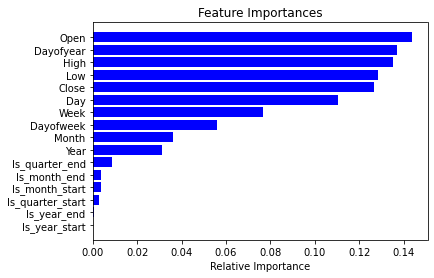

In [31]:
importances = model.best_estimator_.feature_importances_
indices = np.argsort(importances)
# summarize feature importance
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Plotting Coeff for LogReg

In [ ]:
Coef = abs(model.best_estimator_.coef_[0])
ColumnNames = X_train.columns
lg_df = pd.DataFrame(Coef, ColumnNames, columns = ["Coef"])
lg_df_sorted = lg_df.sort_values('Coef',ascending=False)
lg_df_sorted['ColumnNames'] = lg_df_sorted.index
lg_df_sorted['Coef'] = lg_df_sorted['Coef'].divide(max(lg_df_sorted['Coef']))

plt.bar('ColumnNames', 'Coef', data = lg_df_sorted)
plt.xticks(rotation=90)
plt.show()

## Train on entire dataset

In [ ]:
model.fit(X_trainW, Y_trainW)

## Generate submission file

In [ ]:
Y_test_preds = model.predict_proba(X_test)[:,1]
Y_test = submitformat(Y_test_preds, test)

### Save Model

In [ ]:
save_path = '/Users/Kapil/PycharmProjects/stock-price/models/non-lag/'
model_name = model.__class__.__name__ + '.joblib'
joblib.dump(model, save_path + model_name)


In [165]:
Y_test_preds.to_csv('/Users/Kapil/Desktop/Y_test.csv')
